In [69]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from predicting_forest_fires.data.processing import (
    load_data,
    split_data,
    optimum_k,
    hybrid_cluster_outlier_removal,
    encode_feature,
    scale_feature,
)

Loading the data

In [70]:
df = load_data("/Users/josephobukofe/predicting_forest_fires/data/raw/forestfires_classification-1.csv")

In [71]:
df.head(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,F
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,F
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,F
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,F
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,F
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,F
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,F
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,F
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,F
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,F


Investigating the shape of the dataset

In [72]:
df.shape

(517, 13)

Investigating the data types of the features in the dataset

In [73]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area      object
dtype: object

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    object 
dtypes: float64(7), int64(3), object(3)
memory usage: 52.6+ KB


Descriptive statistics of the dataset

In [75]:
df.describe(include = "all")

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517,517,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517
unique,NaN,NaN,12,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,aug,sun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T
freq,NaN,NaN,184,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292
mean,4.669246,4.299807,NaN,NaN,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,NaN
std,2.313778,1.229900,NaN,NaN,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,NaN
min,1.000000,2.000000,NaN,NaN,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,NaN
25%,3.000000,4.000000,NaN,NaN,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,NaN
50%,4.000000,4.000000,NaN,NaN,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,NaN
75%,7.000000,5.000000,NaN,NaN,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,NaN


Investigating the number of null values

In [76]:
df.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

Investigating the number of duplicated rows

In [77]:
df_copy = df.copy()

In [78]:
print('Duplicated Rows: %s'%df_copy.duplicated().sum())

Duplicated Rows: 13


Dropping Duplicates

In [79]:
df_copy = df_copy.drop_duplicates().reset_index(drop = True)

In [80]:
print('Duplicated Rows: %s'%df_copy.duplicated().sum())

Duplicated Rows: 0


In [81]:
df_copy.shape

(504, 13)

Investigating the number of unique values for each feature

In [82]:
df_copy.nunique().sort_values(ascending = False)

DC       219
DMC      215
temp     192
ISI      119
FFMC     106
RH        75
wind      21
month     12
X          9
Y          7
day        7
rain       7
area       2
dtype: int64

#### Data Preprocessing

Treating the X and Y coordinates as a categorical "zones"

In [83]:
df_copy["grid_zone"] = df_copy["X"].astype(str) + "_" + df_copy['Y'].astype(str)

Dropping the original X and Y coordinates

In [84]:
df_copy = df_copy.drop(columns = ["X", "Y"], axis = 1)
df_copy

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,grid_zone
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,F,7_5
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,F,7_4
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,F,7_4
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,F,8_6
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,F,8_6
...,...,...,...,...,...,...,...,...,...,...,...,...
499,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,T,4_3
500,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,T,2_4
501,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,T,7_4
502,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,T,1_4


Replacing "T" and "F" in the target variable to "0" and "1"

In [85]:
df_copy.replace({"T": 1, "F": 0}, inplace = True)
df_copy

/var/folders/vm/d2f62v6j41d08cgh9snhl4k40000gn/T/ipykernel_5599/158289338.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy.replace({"T": 1, "F": 0}, inplace = True)


,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,grid_zone
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0,7_5
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,7_4
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,7_4
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0,8_6
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,8_6
...,...,...,...,...,...,...,...,...,...,...,...,...
499,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,1,4_3
500,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,1,2_4
501,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,1,7_4
502,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,1,1_4


### Exploratory Data Analysis (EDA)

#### Univariate Analysis

Plot of the month feature

In [86]:
sns.set_style('whitegrid')

<Axes: xlabel='month', ylabel='count'>

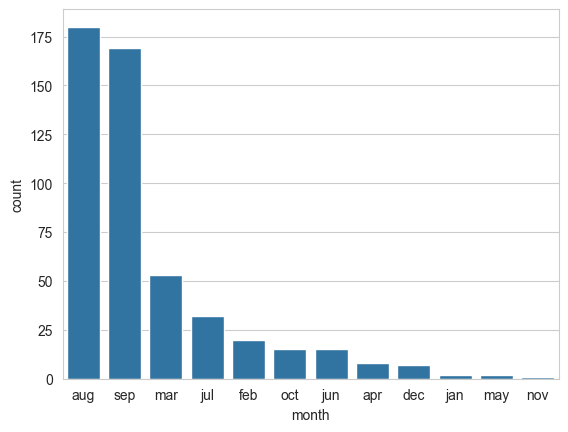

In [87]:
sns.countplot(x = "month", data=df_copy, order=df_copy["month"].value_counts().sort_values(ascending=False).index)

Plot of the day feature

<Axes: xlabel='day', ylabel='count'>

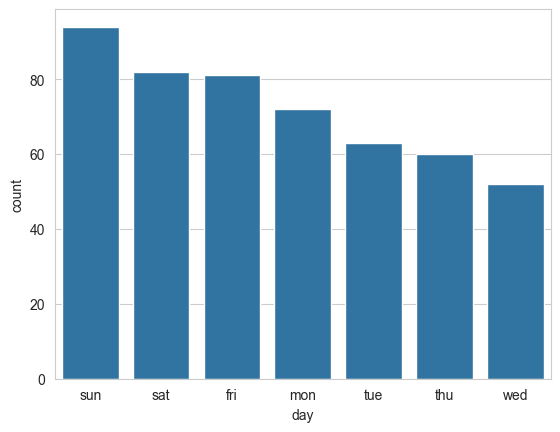

In [88]:
sns.countplot(x = "day", data=df_copy, order=df_copy["day"].value_counts().sort_values(ascending=False).index)

Distribution of the Fine Fuel Moisture Code Index

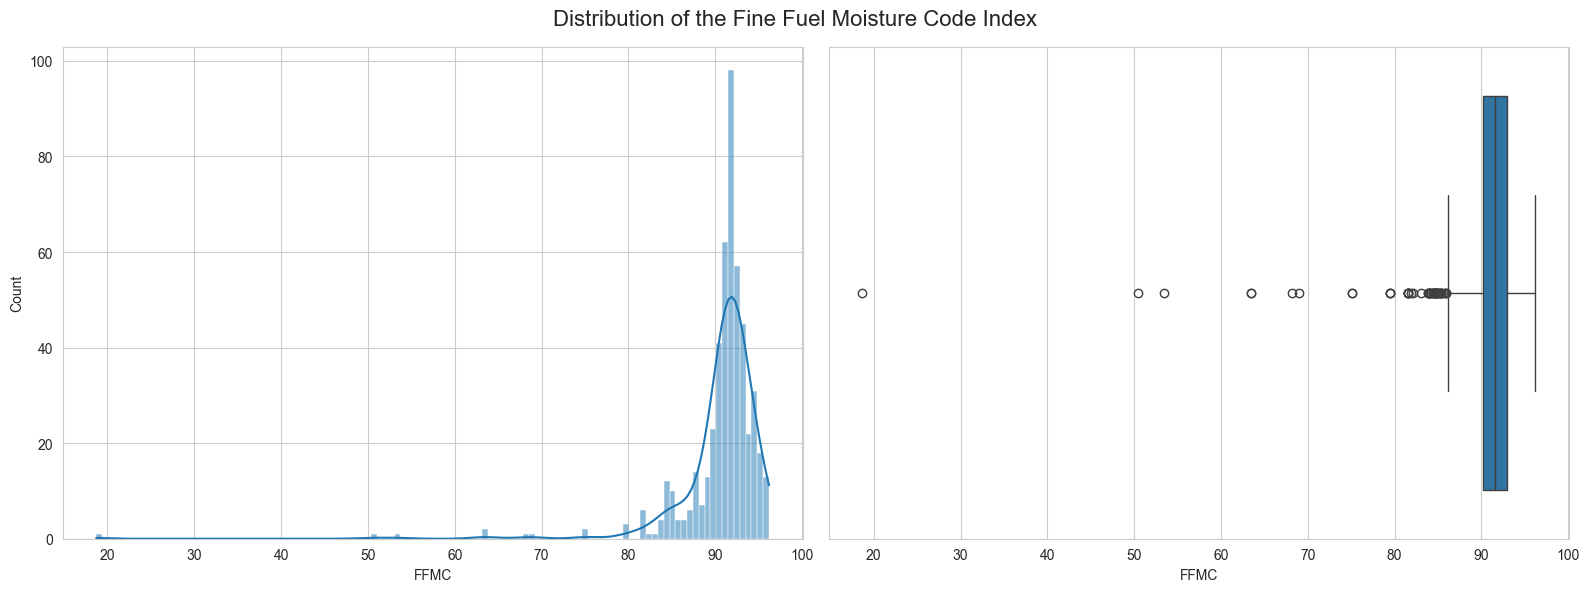

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16, 6))
fig.suptitle('Distribution of the Fine Fuel Moisture Code Index', fontsize=16)

sns.histplot(data=df_copy, x = "FFMC", kde = True, ax=axes[0])
sns.boxplot(data=df_copy, x = "FFMC", ax=axes[1])

plt.tight_layout()
plt.show()

Distribution of the Duff Moisture Code Index

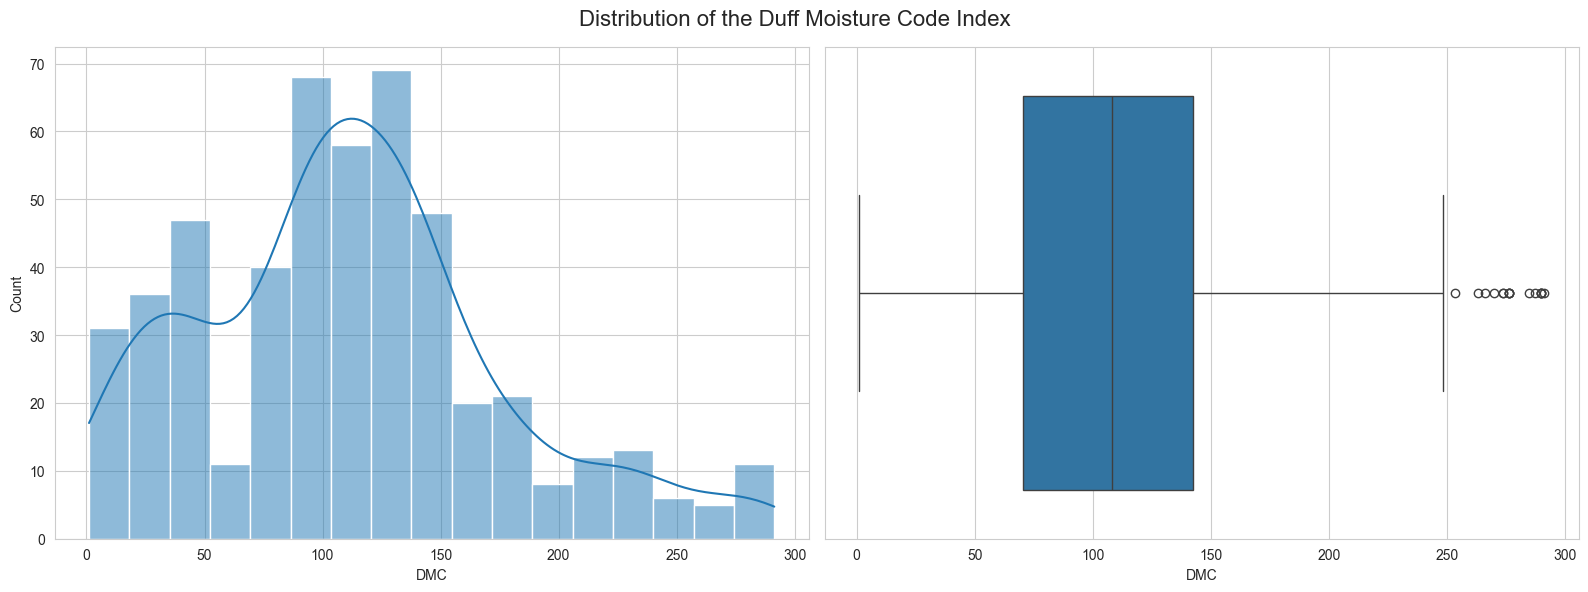

In [90]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16, 6))
fig.suptitle('Distribution of the Duff Moisture Code Index', fontsize=16)

sns.histplot(data=df_copy, x = "DMC", kde = True, ax=axes[0])
sns.boxplot(data=df_copy, x = "DMC", ax=axes[1])

plt.tight_layout()
plt.show()

Distribution of the Drought Code Index

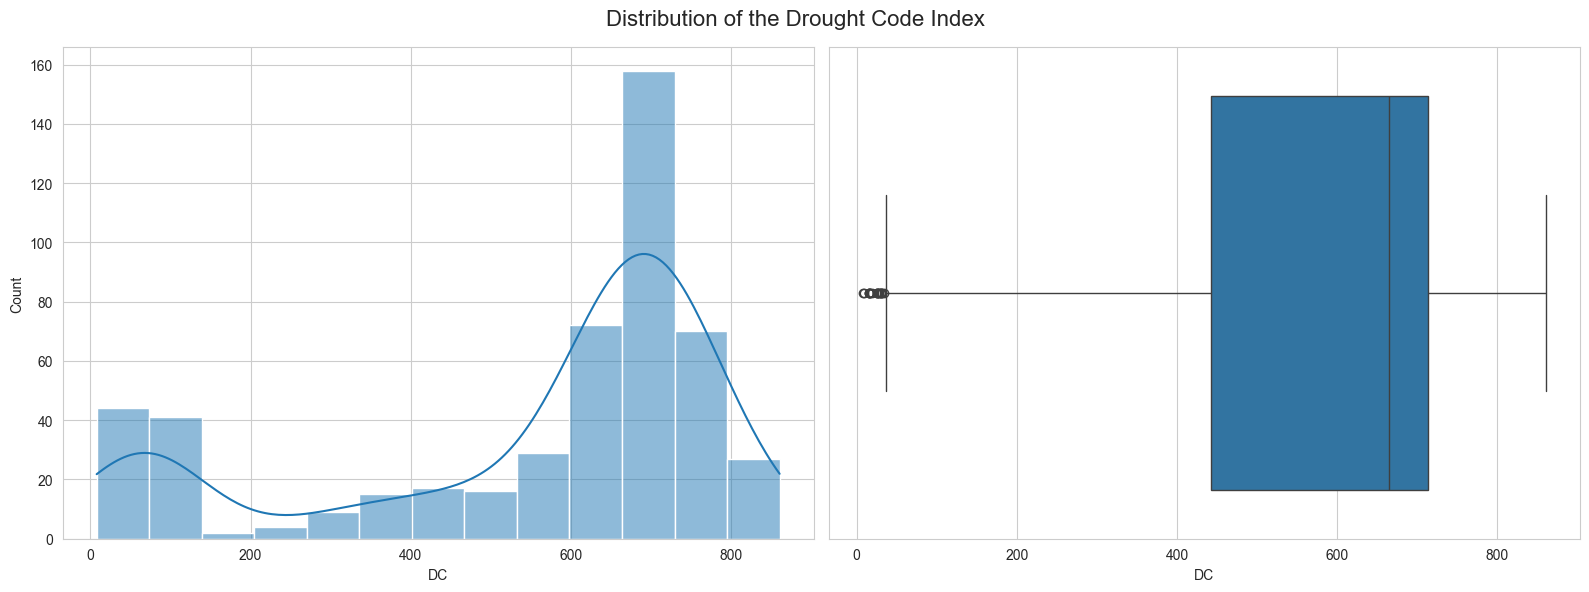

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16, 6))
fig.suptitle('Distribution of the Drought Code Index', fontsize=16)

sns.histplot(data=df_copy, x = "DC", kde = True, ax=axes[0])
sns.boxplot(data=df_copy, x = "DC", ax=axes[1])

plt.tight_layout()
plt.show()

Distribution of the Initial Spread Index

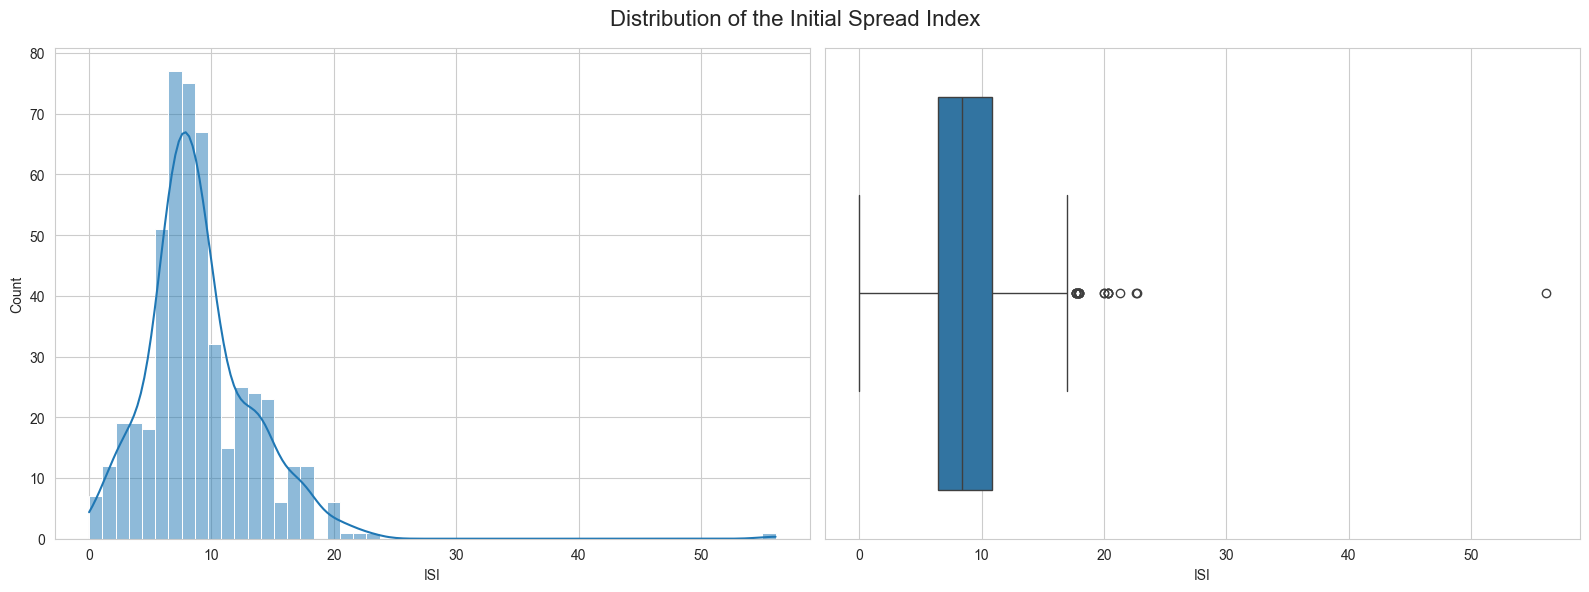

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16, 6))
fig.suptitle('Distribution of the Initial Spread Index', fontsize=16)

sns.histplot(data=df_copy, x = "ISI", kde = True, ax=axes[0])
sns.boxplot(data=df_copy, x = "ISI", ax=axes[1])

plt.tight_layout() 
plt.show()

Distribution of the Temperature in Celsius

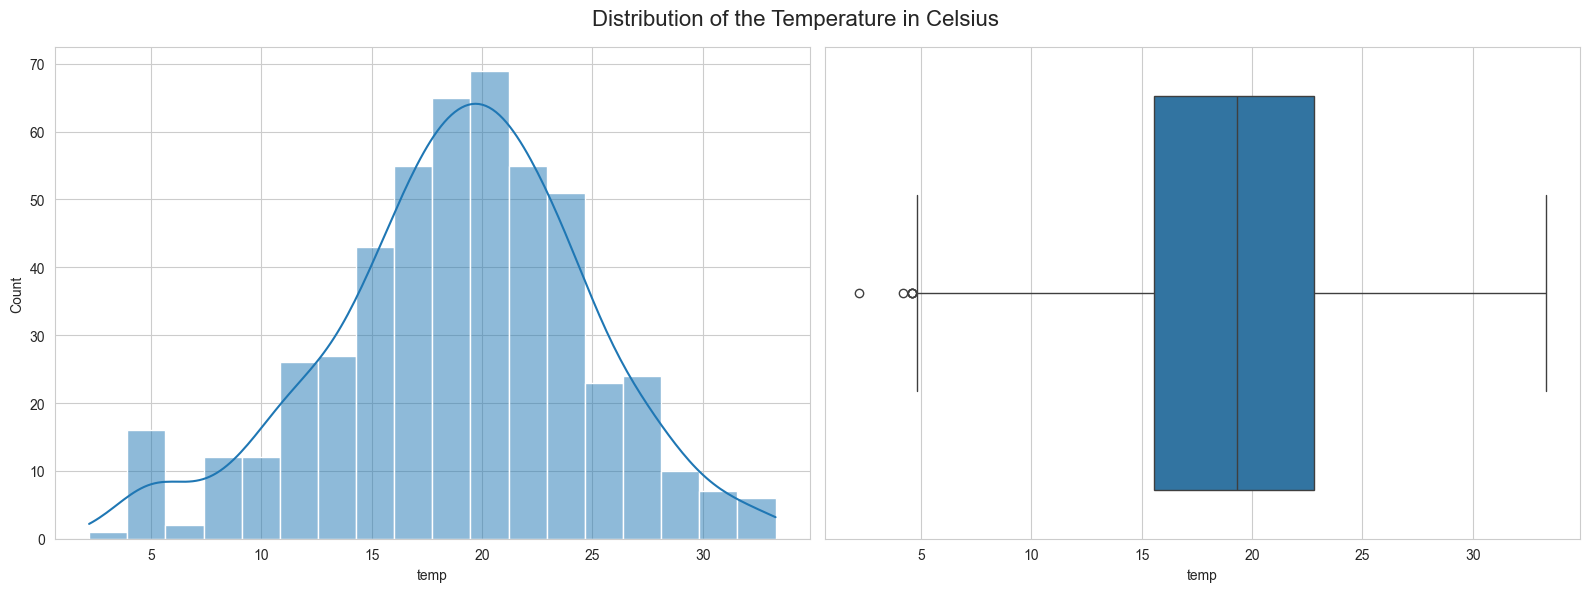

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16, 6))
fig.suptitle('Distribution of the Temperature in Celsius', fontsize=16)

sns.histplot(data=df_copy, x = "temp", kde = True, ax=axes[0])
sns.boxplot(data=df_copy, x = "temp", ax=axes[1])

plt.tight_layout()
plt.show()

Distribution of the Relative Humidity in %

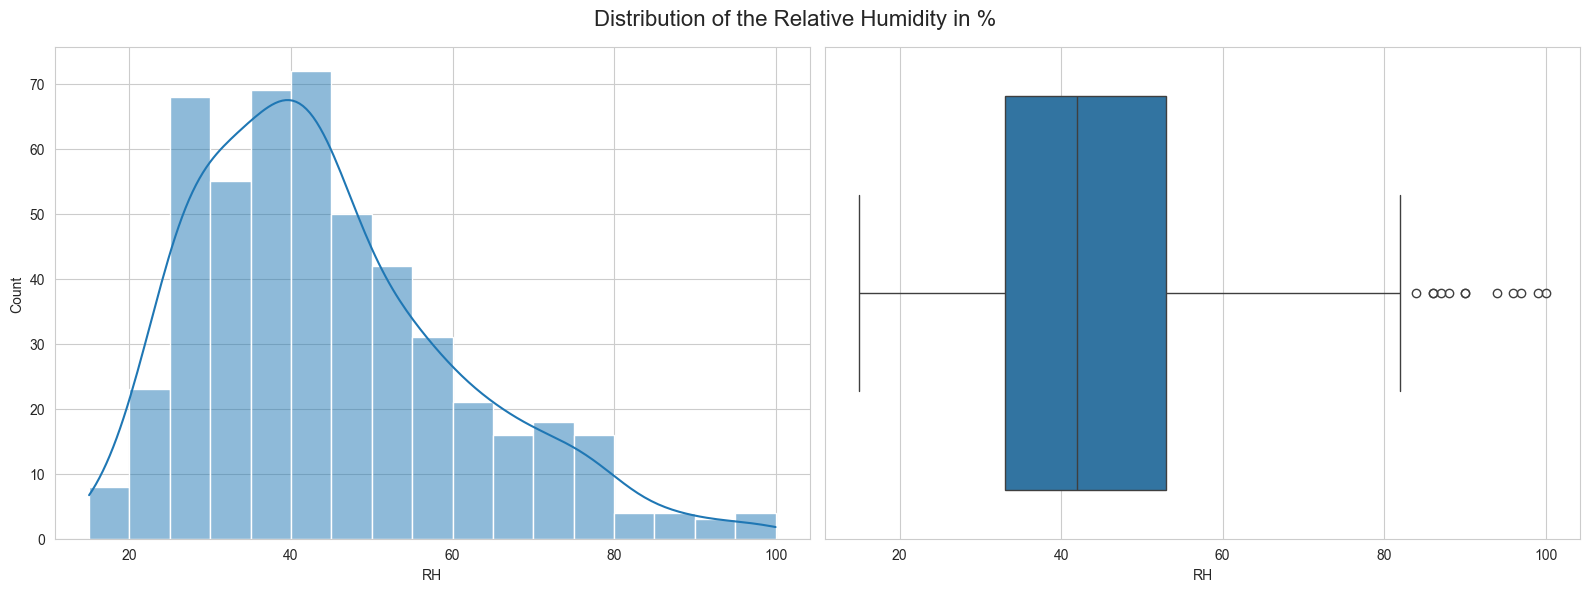

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16, 6))
fig.suptitle('Distribution of the Relative Humidity in %', fontsize=16)

sns.histplot(data=df_copy, x = "RH", kde = True, ax=axes[0])
sns.boxplot(data=df_copy, x = "RH", ax=axes[1])

plt.tight_layout()
plt.show()

Distribution of the Wind Speed in km/h

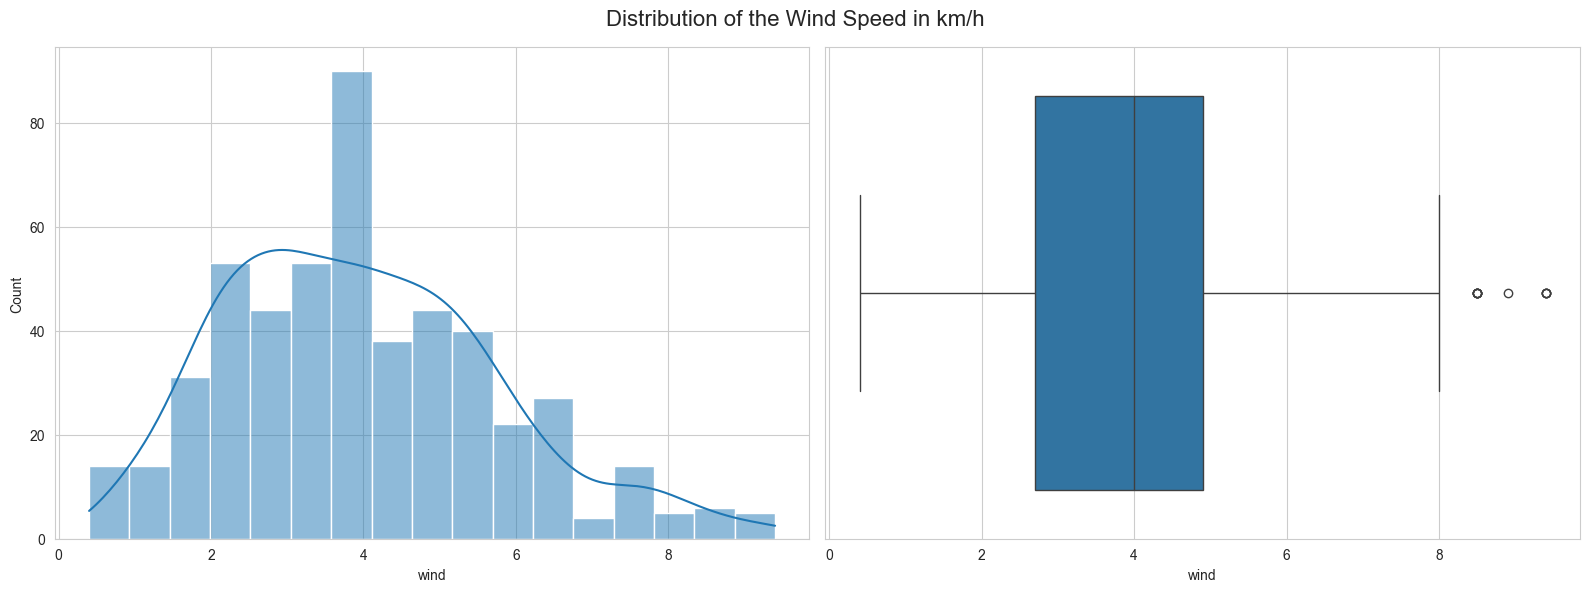

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16, 6))
fig.suptitle('Distribution of the Wind Speed in km/h', fontsize=16)

sns.histplot(data=df_copy, x = "wind", kde = True, ax=axes[0])
sns.boxplot(data=df_copy, x = "wind", ax=axes[1])

plt.tight_layout()
plt.show()

Distribution of the Outside Rain in mm/m

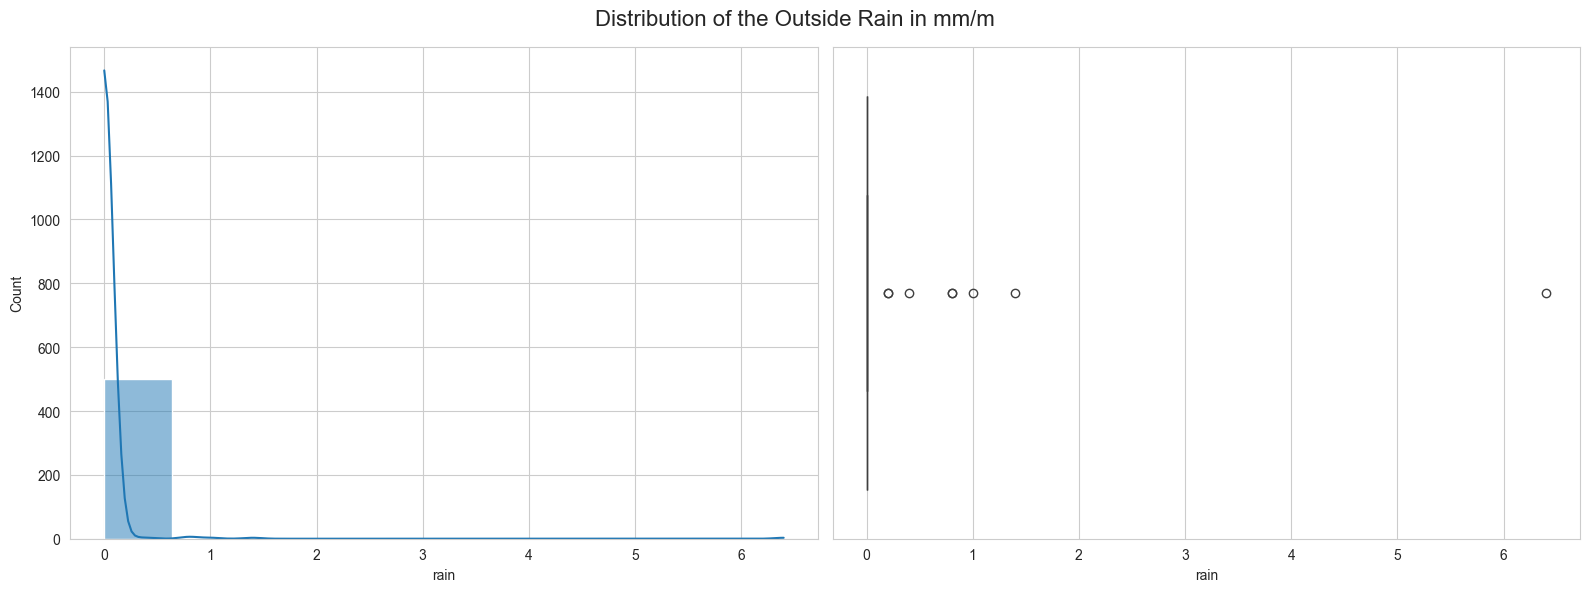

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16, 6))
fig.suptitle('Distribution of the Outside Rain in mm/m', fontsize=16)

sns.histplot(data=df_copy, x = "rain", kde = True, ax=axes[0])
sns.boxplot(data=df_copy, x = "rain", ax=axes[1])

plt.tight_layout()
plt.show()

Binning the outside rain feature into binary categories

In [97]:
df_copy["rain_binned"] = df_copy["rain"].apply(lambda x: 1 if x > 0 else 0)
df_copy["rain_binned"].value_counts()

rain_binned
0    496
1      8
Name: count, dtype: int64

Checking for the presence of negative values in the skewed features: FFMC, ISI

In [98]:
negative_columns = df_copy[["FFMC", "ISI"]] < 0
columns_with_negatives = negative_columns.any()
print(columns_with_negatives)

FFMC    False
ISI     False
dtype: bool


Checking for the presence of zeros, as well as the count in each skewed feature

In [99]:
zeros_columns = df_copy[["FFMC", "ISI"]] == 0.0
columns_with_zeros = zeros_columns.any()
print(columns_with_zeros)

FFMC    False
ISI      True
dtype: bool


Investigating the count of zeros in the identified zero columns

In [100]:
new_zeros_column = df_copy["ISI"] == 0.0
count_of_zeros = new_zeros_column.sum()
print(count_of_zeros)

1


Applying an improved log transform to handle the zero value in the positively skewed data

In [101]:
df_copy["log_transformed_ISI"] = np.log(df_copy["ISI"] + 1)

Applying an improved log transform on the negatively skewed data

In [102]:
shifting_constant = abs(df_copy["FFMC"].min()) + 1
df_copy["FFMC_shifted"] = df_copy["FFMC"] + shifting_constant
df_copy["log_transformed_FFMC"] = np.log(df_copy["FFMC_shifted"])


In [103]:
df_copy

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,grid_zone,rain_binned,log_transformed_ISI,FFMC_shifted,log_transformed_FFMC
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0,7_5,0,1.808289,105.9,4.662495
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,7_4,0,2.041220,110.3,4.703204
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,7_4,0,2.041220,110.3,4.703204
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0,8_6,1,2.302585,111.4,4.713127
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,8_6,0,2.360854,109.0,4.691348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,1,4_3,0,1.064711,101.3,4.618086
500,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,1,2_4,0,1.064711,101.3,4.618086
501,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,1,7_4,0,1.064711,101.3,4.618086
502,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,1,1_4,0,2.509599,114.1,4.737075


Dropping the pre-transformed columns

In [104]:
df_copy.drop(columns=["FFMC", "ISI", "rain", "FFMC_shifted"], axis=1, inplace=True)

In [105]:
df_copy

,month,day,DMC,DC,temp,RH,wind,area,grid_zone,rain_binned,log_transformed_ISI,log_transformed_FFMC
0,mar,fri,26.2,94.3,8.2,51,6.7,0,7_5,0,1.808289,4.662495
1,oct,tue,35.4,669.1,18.0,33,0.9,0,7_4,0,2.041220,4.703204
2,oct,sat,43.7,686.9,14.6,33,1.3,0,7_4,0,2.041220,4.703204
3,mar,fri,33.3,77.5,8.3,97,4.0,0,8_6,1,2.302585,4.713127
4,mar,sun,51.3,102.2,11.4,99,1.8,0,8_6,0,2.360854,4.691348
...,...,...,...,...,...,...,...,...,...,...,...,...
499,aug,sun,56.7,665.6,27.8,32,2.7,1,4_3,0,1.064711,4.618086
500,aug,sun,56.7,665.6,21.9,71,5.8,1,2_4,0,1.064711,4.618086
501,aug,sun,56.7,665.6,21.2,70,6.7,1,7_4,0,1.064711,4.618086
502,aug,sat,146.0,614.7,25.6,42,4.0,1,1_4,0,2.509599,4.737075


In [106]:
df_copy.dtypes

month                    object
day                      object
DMC                     float64
DC                      float64
temp                    float64
RH                        int64
wind                    float64
area                      int64
grid_zone                object
rain_binned               int64
log_transformed_ISI     float64
log_transformed_FFMC    float64
dtype: object

Encoding the categorical features

In [107]:
cat_features = list(df_copy.select_dtypes(include=object).columns)
num_features = [feature for feature in list(df_copy.select_dtypes(exclude=object).columns) if feature not in ["area", "rain_binned"]]
num_features


['DMC',
 'DC',
 'temp',
 'RH',
 'wind',
 'log_transformed_ISI',
 'log_transformed_FFMC']

In [108]:
encoded_df_copy, _ = encode_feature(data=df_copy, features=cat_features, encoding_type="nominal")
encoded_df_copy

,DMC,DC,temp,RH,wind,area,rain_binned,log_transformed_ISI,log_transformed_FFMC,month_apr,...,grid_zone_7_6,grid_zone_8_3,grid_zone_8_4,grid_zone_8_5,grid_zone_8_6,grid_zone_8_8,grid_zone_9_4,grid_zone_9_5,grid_zone_9_6,grid_zone_9_9
0,26.2,94.3,8.2,51,6.7,0,0,1.808289,4.662495,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35.4,669.1,18.0,33,0.9,0,0,2.041220,4.703204,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,43.7,686.9,14.6,33,1.3,0,0,2.041220,4.703204,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33.3,77.5,8.3,97,4.0,0,1,2.302585,4.713127,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,51.3,102.2,11.4,99,1.8,0,0,2.360854,4.691348,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,56.7,665.6,27.8,32,2.7,1,0,1.064711,4.618086,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
500,56.7,665.6,21.9,71,5.8,1,0,1.064711,4.618086,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
501,56.7,665.6,21.2,70,6.7,1,0,1.064711,4.618086,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
502,146.0,614.7,25.6,42,4.0,1,0,2.509599,4.737075,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Rescaling the numerical features

In [109]:
rescaled_df_copy, _ = scale_feature(data=encoded_df_copy, features=num_features, scaling_type="robust")
rescaled_df_copy

,area,rain_binned,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,...,grid_zone_9_5,grid_zone_9_6,grid_zone_9_9,DMC,DC,temp,RH,wind,log_transformed_ISI,log_transformed_FFMC
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-1.142957,-2.102507,-1.536332,0.45,1.227273,-0.938507,-2.049125
1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.014957,0.016962,-0.179931,-0.45,-1.409091,-0.432963,-0.371859
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.899478,0.082596,-0.650519,-0.45,-1.227273,-0.432963,-0.371859
3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-1.044174,-2.164454,-1.522491,2.75,0.000000,0.134292,0.037002
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.793739,-2.073378,-1.093426,2.85,-1.000000,0.260756,-0.860348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.718609,0.004056,1.176471,-0.50,-0.590909,-2.552336,-3.878844
500,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.718609,0.004056,0.359862,1.45,0.818182,-2.552336,-3.878844
501,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.718609,0.004056,0.262976,1.40,1.227273,-2.552336,-3.878844
502,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.523826,-0.183628,0.871972,0.00,0.000000,0.583586,1.023697


Identifying and removing outliers by implementing a hybrid k-means and DBSCAN algorithm that uses an optimum k number of clusters to perform the clustering operation

In [110]:
_, kmeans_model = optimum_k(data=rescaled_df_copy)

In [111]:
cleaned_rescaled_df_copy, uncleaned_rescaled_df_copy = hybrid_cluster_outlier_removal(data=rescaled_df_copy, kmeans_model=kmeans_model, dbscan_eps=3.5, dbscan_min_samples=2)
cleaned_rescaled_df_copy

Number of data points: 504
Number of outliers detected: 3
Percentage of outliers: 0.60%


,area,rain_binned,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,...,grid_zone_9_5,grid_zone_9_6,grid_zone_9_9,DMC,DC,temp,RH,wind,log_transformed_ISI,log_transformed_FFMC
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-1.142957,-2.102507,-1.536332,0.45,1.227273,-0.938507,-2.049125
1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.014957,0.016962,-0.179931,-0.45,-1.409091,-0.432963,-0.371859
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.899478,0.082596,-0.650519,-0.45,-1.227273,-0.432963,-0.371859
3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-1.044174,-2.164454,-1.522491,2.75,0.000000,0.134292,0.037002
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.793739,-2.073378,-1.093426,2.85,-1.000000,0.260756,-0.860348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.718609,0.004056,1.176471,-0.50,-0.590909,-2.552336,-3.878844
497,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.718609,0.004056,0.359862,1.45,0.818182,-2.552336,-3.878844
498,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.718609,0.004056,0.262976,1.40,1.227273,-2.552336,-3.878844
499,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.523826,-0.183628,0.871972,0.00,0.000000,0.583586,1.023697


Dimensionality reduction by implementing the PCA algorithm to represent the data in 2D by 2 components

In [112]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(rescaled_df_copy.drop(columns=['DBSCAN_Outlier']))
pca_rescaled_df_copy = pd.DataFrame(pca_features, columns = ["PC1", "PC2"])
pca_rescaled_df_copy["DBSCAN_Outlier"] = rescaled_df_copy["DBSCAN_Outlier"]

In [113]:
pca_rescaled_df_copy.columns

Index(['PC1', 'PC2', 'DBSCAN_Outlier'], dtype='object')

Visualizing the plot of the clusters and the identified outliers

<Axes: xlabel='PC1', ylabel='PC2'>

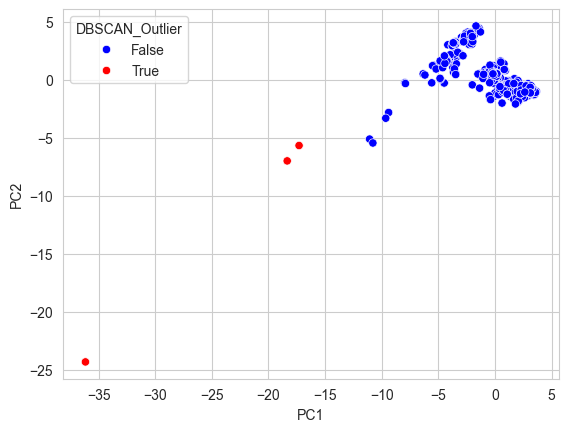

In [114]:
sns.scatterplot(data=pca_rescaled_df_copy, x='PC1', y='PC2', hue='DBSCAN_Outlier', palette={False: 'blue', True: 'red'})

Removing the identified outliers

In [115]:
pca_rescaled_df_copy_indices = cleaned_rescaled_df_copy.index
df_copy_cleaned = cleaned_rescaled_df_copy.loc[pca_rescaled_df_copy_indices].reset_index(drop=True)
df_copy_cleaned

,area,rain_binned,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,...,grid_zone_9_5,grid_zone_9_6,grid_zone_9_9,DMC,DC,temp,RH,wind,log_transformed_ISI,log_transformed_FFMC
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-1.142957,-2.102507,-1.536332,0.45,1.227273,-0.938507,-2.049125
1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.014957,0.016962,-0.179931,-0.45,-1.409091,-0.432963,-0.371859
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.899478,0.082596,-0.650519,-0.45,-1.227273,-0.432963,-0.371859
3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-1.044174,-2.164454,-1.522491,2.75,0.000000,0.134292,0.037002
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.793739,-2.073378,-1.093426,2.85,-1.000000,0.260756,-0.860348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.718609,0.004056,1.176471,-0.50,-0.590909,-2.552336,-3.878844
497,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.718609,0.004056,0.359862,1.45,0.818182,-2.552336,-3.878844
498,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.718609,0.004056,0.262976,1.40,1.227273,-2.552336,-3.878844
499,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.523826,-0.183628,0.871972,0.00,0.000000,0.583586,1.023697


#### Feature Selection

Preparing the dataset for feature selection

In [116]:
target = "area"
features = df_copy_cleaned.columns[df_copy_cleaned.columns != target]

X = df_copy_cleaned[features]
y = df_copy_cleaned[target]

X_train, X_test, y_train, y_test = split_data(X, y)

Training a Logistic Regression model to identify the model coefficients

In [117]:
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X, y)

LogisticRegression(max_iter=1000, random_state=42)

Training a Random Forest Classifier to identify the feature importances

In [118]:
rand_for_model = RandomForestClassifier(n_estimators=100, random_state=42)
rand_for_model.fit(X, y)

RandomForestClassifier(random_state=42)

Extracting the model coefficients from the fitted Linear Regression model

In [119]:
log_reg_model_coefficients = np.abs(log_reg_model.coef_[0])
log_reg_model_coefficients

array([0.3134828 , 1.22340624, 1.5409779 , 1.70013471, 1.47159254,
       0.29838096, 0.17410449, 0.5862583 , 1.04200466, 0.61378588,
       0.57362471, 1.72934209, 1.68905145, 0.07493311, 0.15371282,
       0.1247109 , 0.08812082, 0.14971619, 0.02816411, 0.15688094,
       1.11572039, 0.24343871, 0.76259007, 0.76755043, 0.87952778,
       0.356105  , 0.93169635, 0.24080584, 0.45184915, 0.10635892,
       0.68032373, 0.53373405, 0.39914926, 0.12267911, 0.12602308,
       0.05373497, 0.22957022, 0.99034493, 0.52862881, 0.34004414,
       0.25594663, 0.6897948 , 0.083755  , 0.28144337, 0.13295393,
       0.04730867, 0.07218842, 0.32300219, 0.03664813, 0.04620813,
       0.02163987, 0.11084589, 0.82252842, 0.24011228, 0.03887772,
       0.94402477, 1.26861677, 0.32193162, 0.37968562, 0.29893752,
       0.17160714, 0.41421319, 0.22139297])

Extracting the feature importances from the fitted Random Forest Classifier model

In [120]:
rand_for_model_coefficients = np.array(rand_for_model.feature_importances_)
rand_for_model_coefficients_to_df = pd.DataFrame(rand_for_model_coefficients)
rand_for_model_coefficients_to_df.sort_values(by=0, ascending=False)

,0
57,1.826007e-01
56,1.742743e-01
58,8.967525e-02
62,8.032106e-02
61,7.125853e-02
...,...
51,1.121300e-04
48,6.065215e-06
28,8.653110e-07
54,0.000000e+00


Setting a feature threshold of above the 10th percentile

In [121]:
log_reg_model_coefficient_threshold = np.percentile(log_reg_model_coefficients, 10)
rand_for_model_coefficient_threshold = np.percentile(rand_for_model_coefficients, 10)

Removing the least important features that fall below the set threshold

In [122]:
log_reg_model_important_coefficients = [feature for feature, coef in zip(X.columns, log_reg_model_coefficients) if coef > log_reg_model_coefficient_threshold]
rand_for_model_important_coefficients = [feature for feature, coef in zip(X.columns, rand_for_model_coefficients) if coef > rand_for_model_coefficient_threshold]

Merging the coefficients into one

In [123]:
log_reg_coef_set = set(log_reg_model_important_coefficients)
rand_for_coef_set = set(rand_for_model_important_coefficients)

combined_coef_set = log_reg_coef_set.union(rand_for_coef_set)

important_coefficients = list(combined_coef_set)
important_coefficients

['grid_zone_8_3',
 'day_mon',
 'rain_binned',
 'grid_zone_4_3',
 'grid_zone_2_3',
 'day_tue',
 'grid_zone_9_5',
 'wind',
 'month_mar',
 'month_feb',
 'day_sun',
 'DMC',
 'grid_zone_5_6',
 'grid_zone_8_6',
 'grid_zone_5_5',
 'grid_zone_4_6',
 'grid_zone_3_4',
 'month_dec',
 'grid_zone_3_6',
 'grid_zone_1_2',
 'month_jul',
 'month_aug',
 'grid_zone_8_8',
 'grid_zone_7_5',
 'RH',
 'grid_zone_7_3',
 'grid_zone_7_6',
 'temp',
 'grid_zone_1_5',
 'day_wed',
 'month_jan',
 'grid_zone_4_5',
 'grid_zone_5_4',
 'DC',
 'day_sat',
 'month_may',
 'grid_zone_2_2',
 'grid_zone_6_6',
 'day_thu',
 'month_nov',
 'grid_zone_7_4',
 'log_transformed_ISI',
 'month_oct',
 'grid_zone_2_4',
 'grid_zone_6_4',
 'grid_zone_1_3',
 'grid_zone_4_4',
 'grid_zone_8_5',
 'log_transformed_FFMC',
 'grid_zone_9_9',
 'grid_zone_1_4',
 'month_jun',
 'month_sep',
 'grid_zone_6_5',
 'day_fri',
 'grid_zone_6_3',
 'grid_zone_2_5',
 'grid_zone_3_3',
 'grid_zone_9_4',
 'month_apr',
 'grid_zone_3_5']

In [124]:
print(f"Number of columns before feature selection: {len(df_copy_cleaned[features].columns)}")
print(f"Number of columns after feature selection: {len(important_coefficients)}")

Number of columns before feature selection: 63
Number of columns after feature selection: 61


In [125]:
cleaned_df = pd.concat([X[important_coefficients], y], axis=1)
cleaned_df

,grid_zone_8_3,day_mon,rain_binned,grid_zone_4_3,grid_zone_2_3,day_tue,grid_zone_9_5,wind,month_mar,month_feb,...,month_sep,grid_zone_6_5,day_fri,grid_zone_6_3,grid_zone_2_5,grid_zone_3_3,grid_zone_9_4,month_apr,grid_zone_3_5,area
0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.227273,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0,0.0,0.0,1.0,0.0,-1.409091,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0,0.0,0.0,0.0,0.0,-1.227273,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,1,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0,0.0,0.0,0.0,0.0,-1.000000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.0,0.0,0,1.0,0.0,0.0,0.0,-0.590909,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
497,0.0,0.0,0,0.0,0.0,0.0,0.0,0.818182,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
498,0.0,0.0,0,0.0,0.0,0.0,0.0,1.227273,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
499,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


#### Multivariate Analysis

Checking for Multicollinearity using the Variance Inflation Factor (VIF)

In [126]:
vif_cleaned_df = pd.DataFrame()
vif_cleaned_df["Feature"] = cleaned_df.columns
vif_cleaned_df["VIF"] = [variance_inflation_factor(cleaned_df.values, i) for i in range(len(cleaned_df.columns))]
vif_cleaned_df

/Users/josephobukofe/Library/Caches/pypoetry/virtualenvs/predicting-forest-fires-i3PHmrBX-py3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,grid_zone_8_3,2.657861
1,day_mon,inf
2,rain_binned,1.333679
3,grid_zone_4_3,11.634858
4,grid_zone_2_3,1.559059
...,...,...
57,grid_zone_3_3,1.547673
58,grid_zone_9_4,3.205251
59,month_apr,inf
60,grid_zone_3_5,4.660315


#### Feature Selection

Removing features with high multicollinearity as a VIF >= 10 suggest high correlation 

In [127]:
vif_processed_df = vif_cleaned_df[vif_cleaned_df["VIF"] <= 10].reset_index(drop=True)
vif_processed_df

,Feature,VIF
0,grid_zone_8_3,2.657861
1,rain_binned,1.333679
2,grid_zone_2_3,1.559059
3,grid_zone_9_5,1.667881
4,wind,1.363026
5,DMC,4.307609
6,grid_zone_5_6,3.121220
7,grid_zone_5_5,2.777931
8,grid_zone_4_6,5.432037
9,grid_zone_3_6,2.649565


In [128]:
processed_df = cleaned_df[vif_processed_df["Feature"]]
processed_df

,grid_zone_8_3,rain_binned,grid_zone_2_3,grid_zone_9_5,wind,DMC,grid_zone_5_6,grid_zone_5_5,grid_zone_4_6,grid_zone_3_6,...,grid_zone_6_4,grid_zone_1_3,grid_zone_8_5,log_transformed_FFMC,grid_zone_9_9,grid_zone_1_4,grid_zone_3_3,grid_zone_9_4,grid_zone_3_5,area
0,0.0,0,0.0,0.0,1.227273,-1.142957,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.049125,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0,0.0,0.0,-1.409091,-1.014957,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.371859,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0,0.0,0.0,-1.227273,-0.899478,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.371859,0.0,0.0,0.0,0.0,0.0,0
3,0.0,1,0.0,0.0,0.000000,-1.044174,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.037002,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0,0.0,0.0,-1.000000,-0.793739,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.860348,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.0,0,0.0,0.0,-0.590909,-0.718609,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.878844,0.0,0.0,0.0,0.0,0.0,1
497,0.0,0,0.0,0.0,0.818182,-0.718609,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.878844,0.0,0.0,0.0,0.0,0.0,1
498,0.0,0,0.0,0.0,1.227273,-0.718609,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.878844,0.0,0.0,0.0,0.0,0.0,1
499,0.0,0,0.0,0.0,0.000000,0.523826,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.023697,0.0,1.0,0.0,0.0,0.0,1


Confirming the majority and minority classes

<Axes: xlabel='area', ylabel='count'>

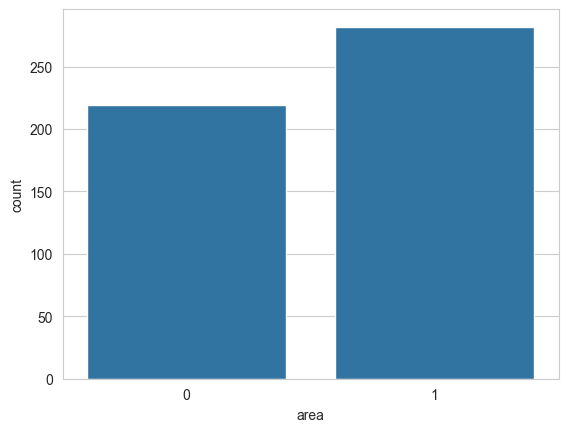

In [129]:
sns.countplot(data=processed_df, x="area")

Identifying the features with the strongest linear relationship with the target

In [130]:
print(processed_df.corr()[target].abs().sort_values(ascending=False))

area                    1.000000
DMC                     0.354544
temp                    0.176882
log_transformed_FFMC    0.113112
grid_zone_3_5           0.100796
RH                      0.086696
grid_zone_1_4           0.083984
rain_binned             0.080157
grid_zone_9_4           0.079059
grid_zone_7_3           0.071840
log_transformed_ISI     0.071811
grid_zone_1_5           0.056586
grid_zone_5_6           0.056586
grid_zone_7_6           0.055791
grid_zone_9_9           0.050948
grid_zone_1_3           0.039452
grid_zone_8_8           0.039411
grid_zone_3_3           0.039411
grid_zone_9_5           0.039411
grid_zone_2_3           0.039411
grid_zone_8_3           0.035917
grid_zone_3_6           0.035917
grid_zone_6_4           0.032292
grid_zone_5_5           0.016241
grid_zone_6_6           0.016241
grid_zone_4_6           0.016147
grid_zone_8_5           0.011371
grid_zone_7_5           0.005262
wind                    0.000403
Name: area, dtype: float64


In [131]:
processed_df["grid_zone_9_5"].value_counts()

grid_zone_9_5
0.0    500
1.0      1
Name: count, dtype: int64

In [132]:
processed_df.drop(columns=["grid_zone_9_5"], inplace=True)

/var/folders/vm/d2f62v6j41d08cgh9snhl4k40000gn/T/ipykernel_5599/1366021584.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df.drop(columns=["grid_zone_9_5"], inplace=True)


Saving the preprocessed DataFrame as a CSV file

In [133]:
processed_df.to_csv("/Users/josephobukofe/predicting_forest_fires/data/processed/preprocessed_forestfires_classification.csv", index=False)